In [3]:
import pandas as pd
import numpy as np
from struct import unpack
from base64 import b64decode
import string
import random

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, concatenate, BatchNormalization, Multiply, Add, Dot
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

In [5]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
IMG_LEN = 1024
TXT_LEN = 300
N_CLASSES = 50

In [7]:
filename = "/Users/dmitry/Downloads/topics_dataset.json"
df = pd.read_json(filename, lines=True)

In [8]:
from functools import partial

def unpck(l, x):
    return unpack('%df' % l, b64decode(x.encode('utf-8')))

unpck_img = partial(unpck, IMG_LEN)
unpck_txt = partial(unpck, TXT_LEN)

In [9]:
x_img = np.stack(df['x1'].map(unpck_img), axis=0)
x_txt = np.stack(df['x2'].map(unpck_txt), axis=0)
y = to_categorical(np.array(df['y1']), N_CLASSES)

In [10]:
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img, 
    x_txt, 
    y, 
    test_size=0.2, 
    random_state=42
)

x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(
    x_img_train,
    x_txt_train,
    y_train,
    test_size=0.2,
    random_state=42
)

In [11]:
img_sscaler = StandardScaler()
img_sscaler.fit(x_img_train)

x_img_train = img_sscaler.transform(x_img_train)
x_img_val = img_sscaler.transform(x_img_val)
x_img_test = img_sscaler.transform(x_img_test)

txt_sscaler = StandardScaler()
txt_sscaler.fit(x_txt_train)

x_txt_train = txt_sscaler.transform(x_txt_train)
x_txt_val = txt_sscaler.transform(x_txt_val)
x_txt_test = txt_sscaler.transform(x_txt_test)

In [56]:
def get_model_one_narrow_dense():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
model_one_narrow_dense = get_model_one_narrow_dense()
model_one_narrow_dense.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 24s 174us/sample - loss: 1.9588 - accuracy: 0.5164 - val_loss: 1.5478 - val_accuracy: 0.5904
Epoch 2/7
135897/135897 [==============================] - 15s 114us/sample - loss: 1.7051 - accuracy: 0.5530 - val_loss: 1.5179 - val_accuracy: 0.5932
Epoch 3/7
135897/135897 [==============================] - 14s 104us/sample - loss: 1.6819 - accuracy: 0.5576 - val_loss: 1.5160 - val_accuracy: 0.5976
Epoch 4/7
135897/135897 [==============================] - 14s 105us/sample - loss: 1.6681 - accuracy: 0.5612 - val_loss: 1.5112 - val_accuracy: 0.6006
Epoch 5/7
135897/135897 [==============================] - 16s 115us/sample - loss: 1.6589 - accuracy: 0.5620 - val_loss: 1.5210 - val_accuracy: 0.5970
Epoch 6/7
135897/135897 [==============================] - 14s 103us/sample - loss: 1.6503 - accuracy: 0.5666 - val_loss: 1.5037 - val_accuracy: 0.5997
Epoch 7/7
135897/135897 [============

In [58]:
y_pred = model_one_narrow_dense.predict([x_img_test, x_txt_test])

In [59]:
np.shape(y_pred.argmax(axis=1))

(42468,)

In [60]:
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [168]:
con_matrix_norm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

In [61]:
pd.DataFrame(con_matrix)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1394,11,0,3,1,2,1,0,0,0,...,0,0,0,1,0,1,1,0,23,0
1,5,955,1,6,2,30,1,4,0,1,...,0,0,0,3,5,7,0,0,28,0
2,0,0,86,12,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,2,0
3,9,3,2,1507,1,1,3,8,1,1,...,0,0,0,0,0,2,0,0,16,1
4,1,4,0,1,162,4,4,2,3,7,...,1,0,0,7,0,24,0,0,6,0
5,3,38,0,3,1,344,5,0,0,0,...,0,10,0,5,0,1,0,0,7,0
6,1,3,0,3,1,5,867,2,1,1,...,0,0,0,3,0,1,0,0,3,1
7,1,3,0,11,0,1,0,395,2,0,...,0,0,0,0,0,1,0,0,1,2
8,0,1,0,4,0,0,7,13,280,3,...,0,0,0,1,0,0,1,0,17,1
9,4,3,0,3,0,0,0,2,1,649,...,1,0,0,2,0,20,1,0,23,0


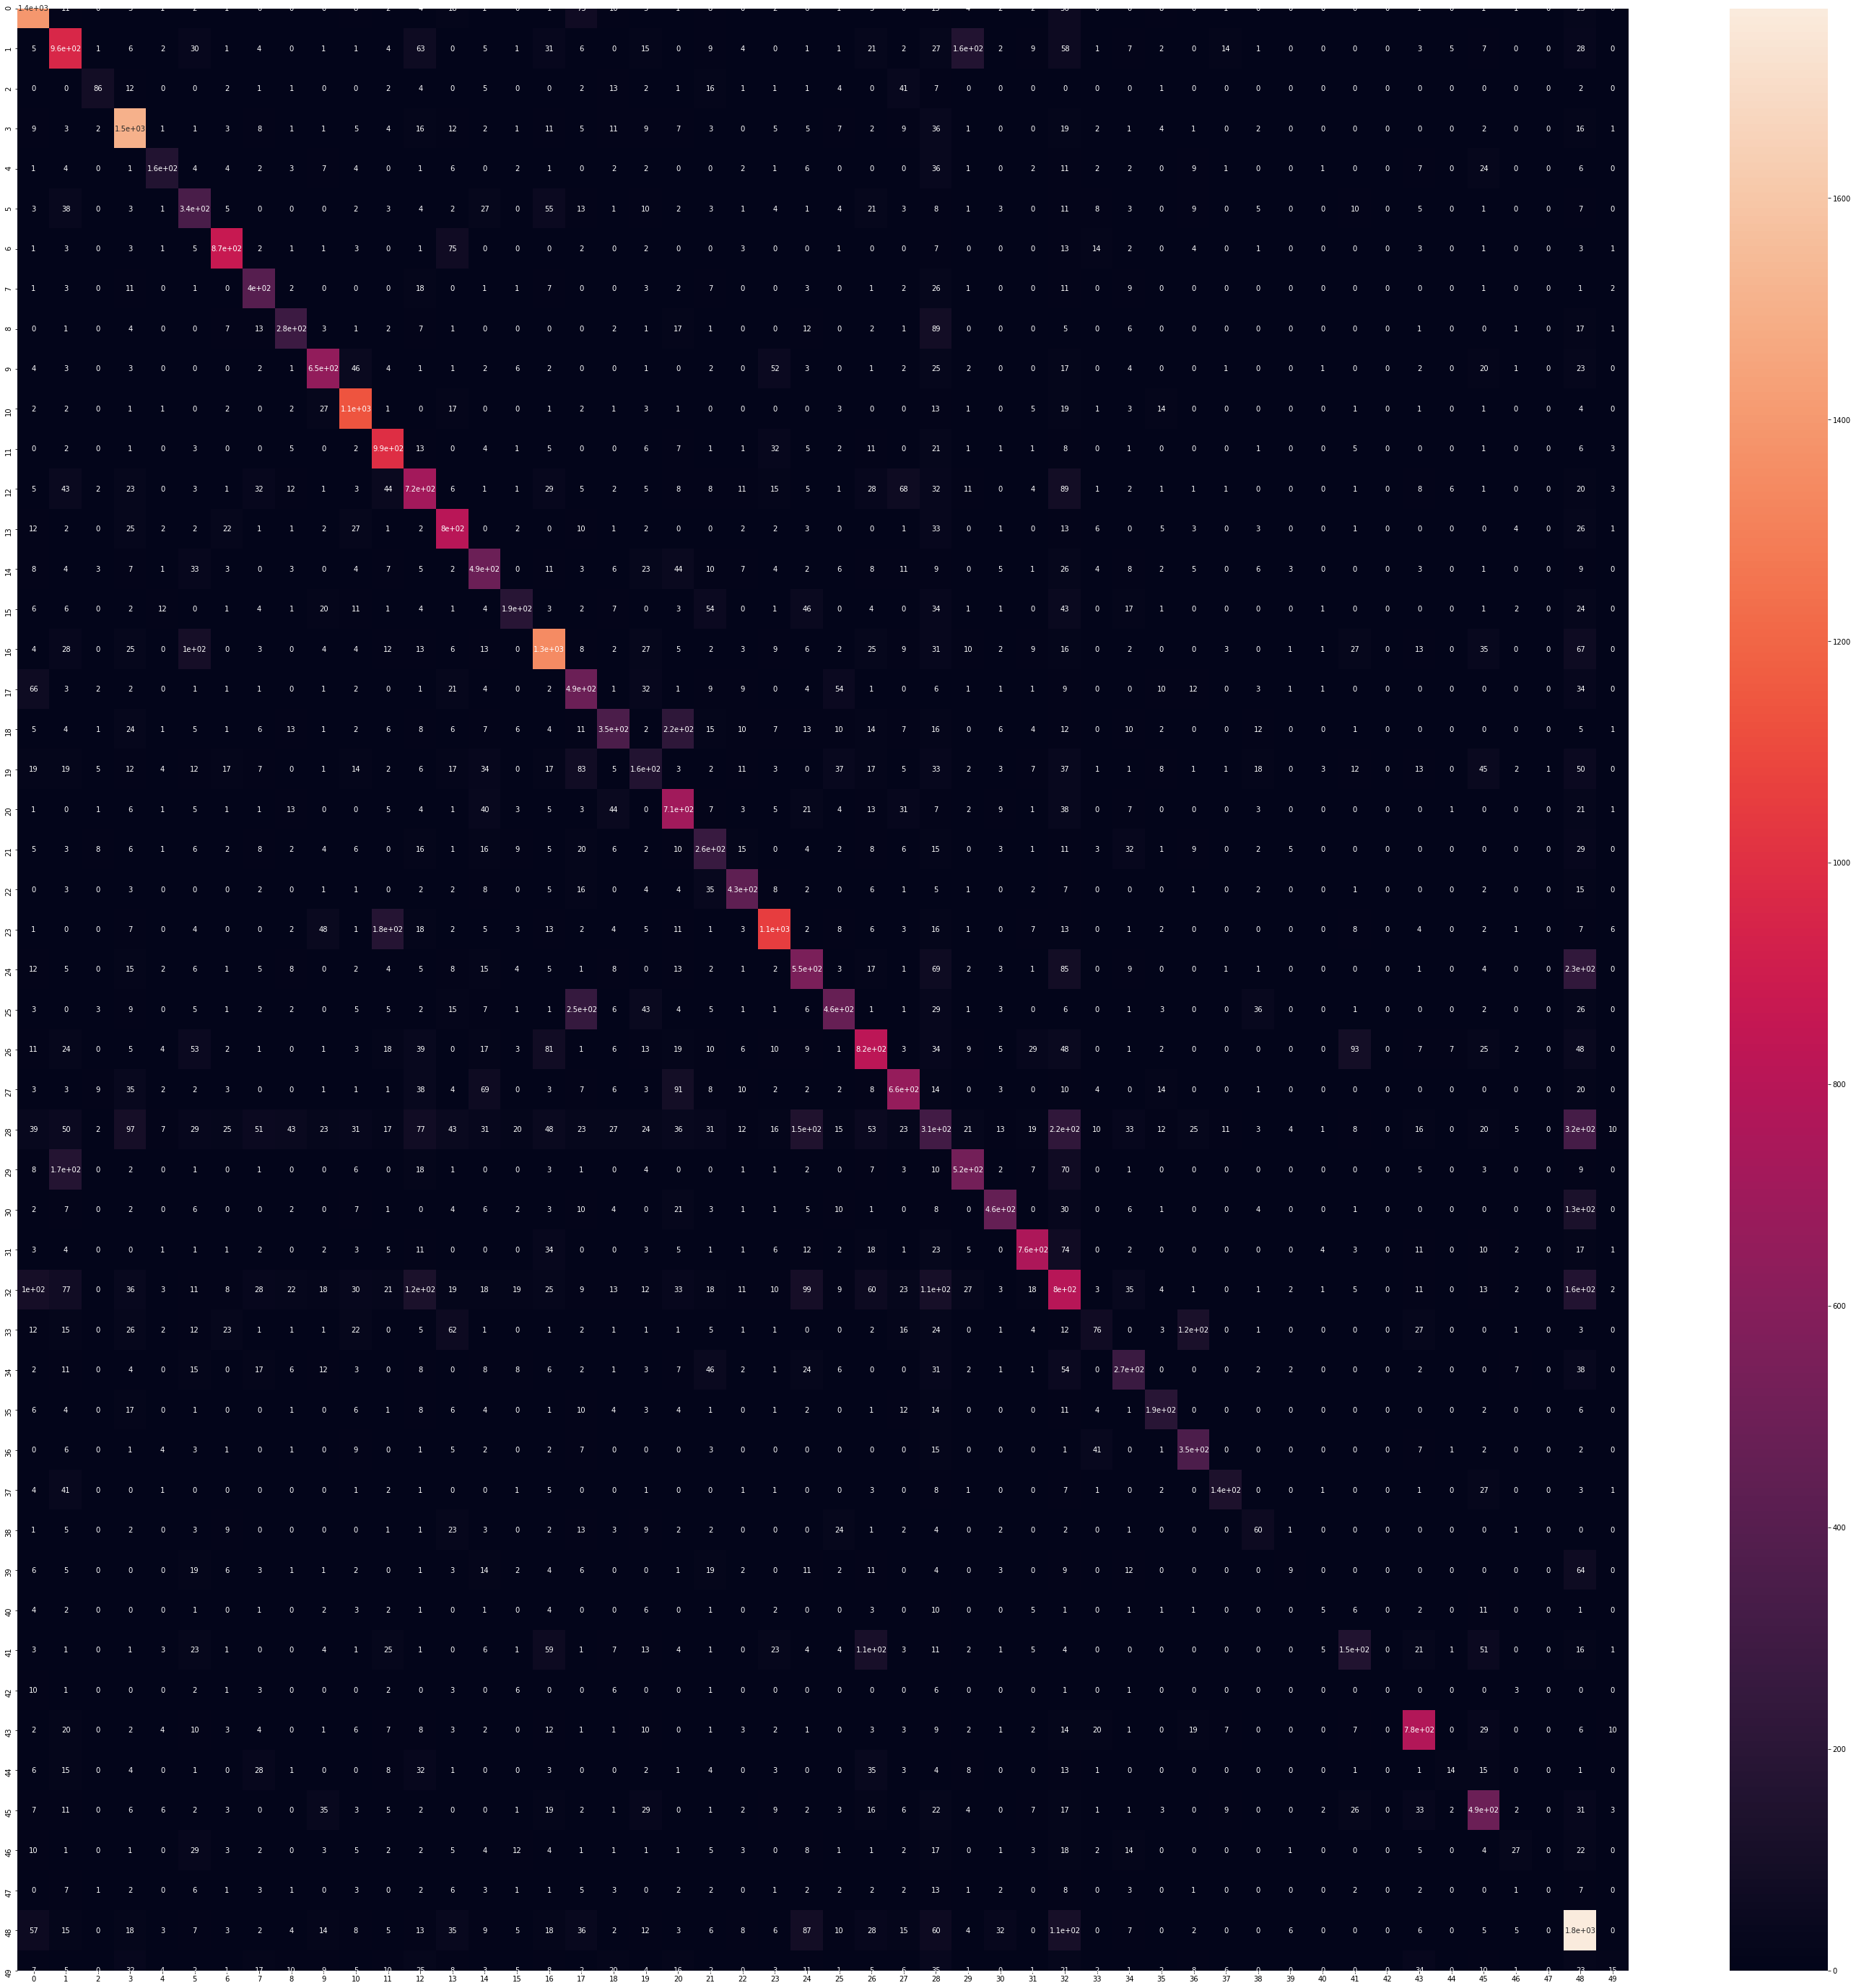

In [70]:
import seaborn as sn

plt.figure(figsize = (50,50))
sn.heatmap(pd.DataFrame(con_matrix), annot=True)

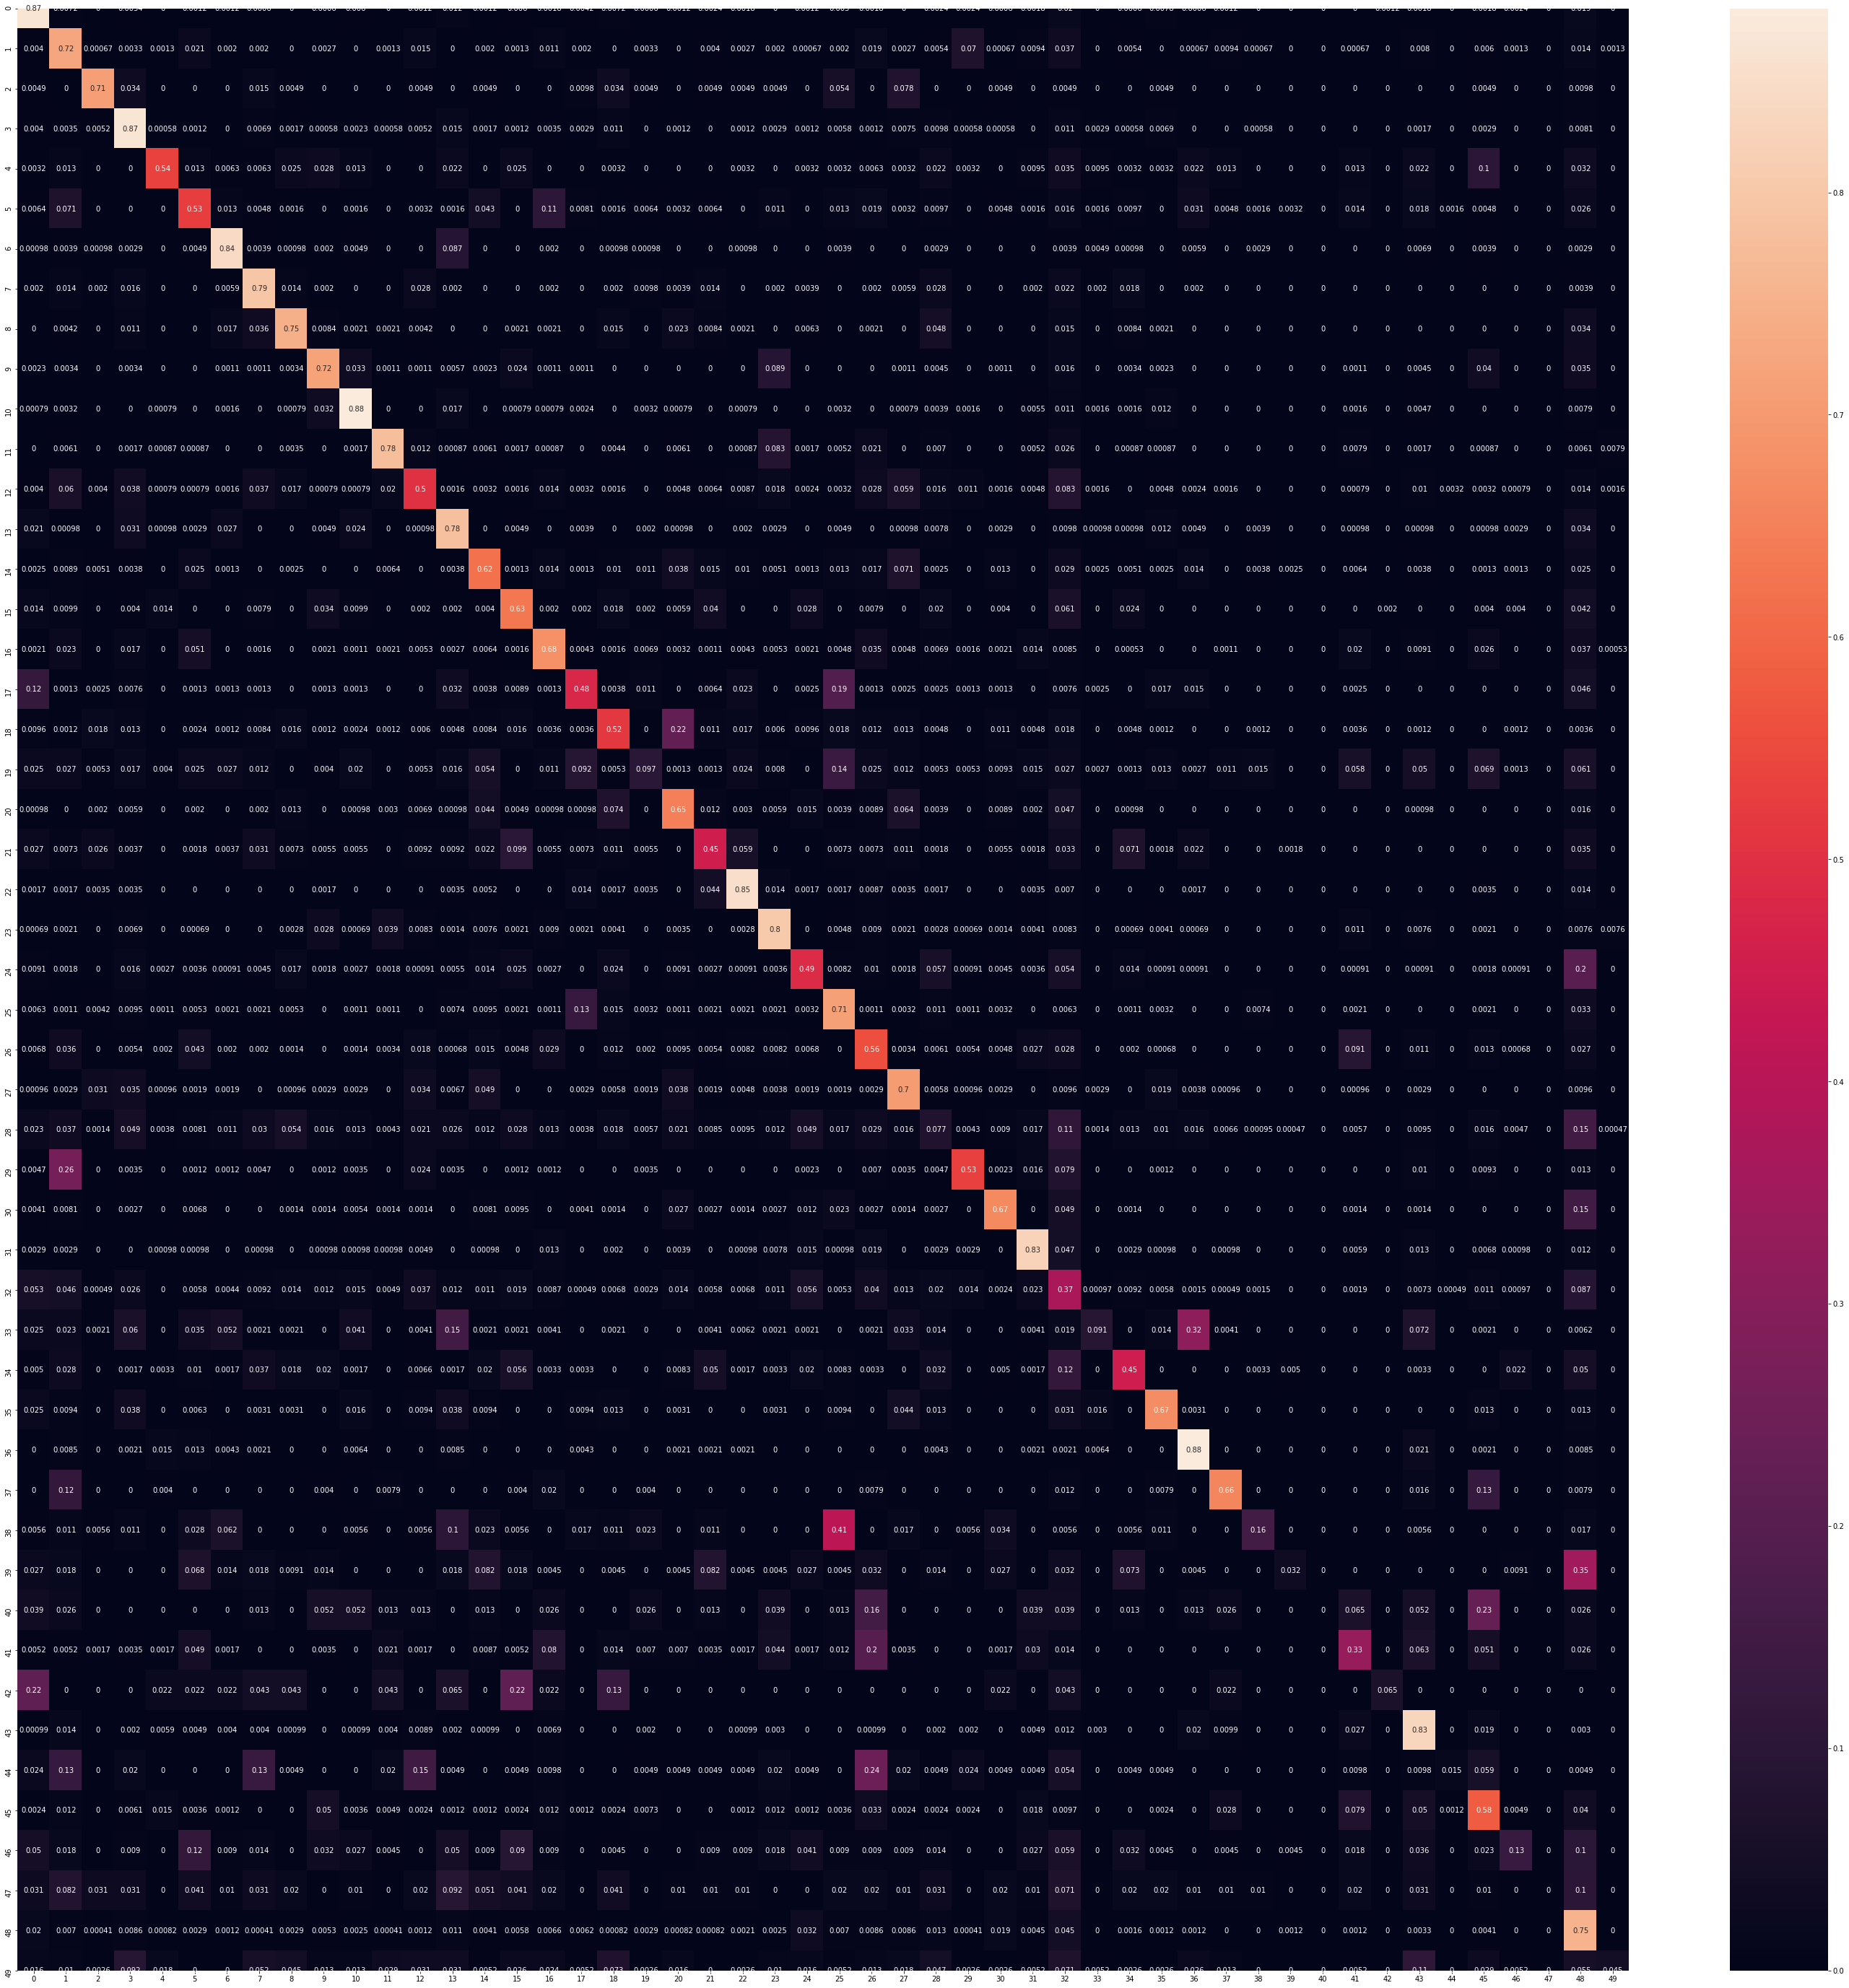

In [173]:
plt.figure(figsize = (50, 50))
sn.heatmap(pd.DataFrame(con_matrix_norm), annot=True)

In [172]:
def get_model_two_narrow_denses():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model_two_narrow_denses = get_model_two_narrow_denses()
model_two_narrow_denses.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 22s 162us/sample - loss: 2.2625 - accuracy: 0.4529 - val_loss: 1.5539 - val_accuracy: 0.5885
Epoch 2/7
135897/135897 [==============================] - 18s 136us/sample - loss: 1.8862 - accuracy: 0.5078 - val_loss: 1.5765 - val_accuracy: 0.5830
Epoch 3/7
135897/135897 [==============================] - 17s 125us/sample - loss: 1.8581 - accuracy: 0.5148 - val_loss: 1.5460 - val_accuracy: 0.5873
Epoch 4/7
135897/135897 [==============================] - 19s 139us/sample - loss: 1.8432 - accuracy: 0.5174 - val_loss: 1.5564 - val_accuracy: 0.5901
Epoch 5/7
135897/135897 [==============================] - 20s 144us/sample - loss: 1.8369 - accuracy: 0.5206 - val_loss: 1.5389 - val_accuracy: 0.5890
Epoch 6/7
135897/135897 [==============================] - 17s 126us/sample - loss: 1.8285 - accuracy: 0.5233 - val_loss: 1.5389 - val_accuracy: 0.5936
Epoch 7/7
135897/135897 [============

In [94]:
def get_model_one_wide_dense():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Dense(1024)(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
model_one_wide_dense = get_model_one_wide_dense()
model_one_wide_dense.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 61s 447us/sample - loss: 2.6965 - accuracy: 0.4794 - val_loss: 2.2655 - val_accuracy: 0.5304
Epoch 2/7
135897/135897 [==============================] - 62s 459us/sample - loss: 2.6588 - accuracy: 0.4898 - val_loss: 2.3617 - val_accuracy: 0.5284
Epoch 3/7
135897/135897 [==============================] - 60s 442us/sample - loss: 2.7685 - accuracy: 0.4924 - val_loss: 2.5129 - val_accuracy: 0.5200
Epoch 4/7
135897/135897 [==============================] - 60s 441us/sample - loss: 2.8305 - accuracy: 0.4934 - val_loss: 2.5601 - val_accuracy: 0.5226
Epoch 5/7
135897/135897 [==============================] - 67s 494us/sample - loss: 2.8836 - accuracy: 0.4939 - val_loss: 2.5930 - val_accuracy: 0.5316
Epoch 6/7
135897/135897 [==============================] - 59s 436us/sample - loss: 2.9195 - accuracy: 0.4958 - val_loss: 2.6512 - val_accuracy: 0.5157
Epoch 7/7
135897/135897 [============

In [95]:
def get_model_two_wide_denses():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Dense(1024)(x)
    x = Dropout(0.5)(x)
    x = Dense(1024)(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model_two_wide_denses = get_model_two_wide_denses()
model_two_wide_denses.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 121s 894us/sample - loss: 4.8530 - accuracy: 0.4107 - val_loss: 4.9928 - val_accuracy: 0.4696
Epoch 2/7
135897/135897 [==============================] - 101s 742us/sample - loss: 6.4348 - accuracy: 0.4170 - val_loss: 5.1644 - val_accuracy: 0.4938
Epoch 3/7
135897/135897 [==============================] - 103s 757us/sample - loss: 7.3466 - accuracy: 0.4246 - val_loss: 5.6187 - val_accuracy: 0.5042
Epoch 4/7
135897/135897 [==============================] - 106s 783us/sample - loss: 8.0529 - accuracy: 0.4257 - val_loss: 6.1613 - val_accuracy: 0.5066
Epoch 5/7
135897/135897 [==============================] - 104s 764us/sample - loss: 8.4779 - accuracy: 0.4299 - val_loss: 6.6088 - val_accuracy: 0.5114
Epoch 6/7
135897/135897 [==============================] - 119s 874us/sample - loss: 8.8791 - accuracy: 0.4313 - val_loss: 6.8142 - val_accuracy: 0.5029
Epoch 7/7
135897/135897 [======

In [96]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings

from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.generic_utils import to_list
from  tensorflow.keras import regularizers 
from tensorflow.keras import constraints
from tensorflow.keras import activations
from tensorflow.keras import initializers

class Highway(Layer):
    """Densely connected highway network.
    Highway layers are a natural extension of LSTMs to feedforward networks.
    # Arguments
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights
            initialization. This parameter is only relevant
            if you don't pass a `weights` argument.
        activation: name of activation function to use
            (see [activations](../activations.md)),
            or alternatively, elementwise Theano function.
            If you don't specify anything, no activation is applied
            (ie. "linear" activation: a(x) = x).
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        b_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the bias.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        b_constraint: instance of the [constraints](../constraints.md) module,
            applied to the bias.
        bias: whether to include a bias
            (i.e. make the layer affine rather than linear).
        input_dim: dimensionality of the input (integer). This argument
            (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # References
        - [Highway Networks](http://arxiv.org/abs/1505.00387v2)
    """

    def __init__(self,
                 init='glorot_uniform',
                 activation=None,
                 weights=None,
                 W_regularizer=None,
                 b_regularizer=None,
                 activity_regularizer=None,
                 W_constraint=None,
                 b_constraint=None,
                 bias=True,
                 input_dim=None,
                 **kwargs):
        
        if 'transform_bias' in kwargs:
            kwargs.pop('transform_bias')
            warnings.warn('`transform_bias` argument is deprecated and '
                          'has been removed.')
        self.init = initializers.get(init)
        self.activation = activations.get(activation)

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

        self.input_dim = input_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(),
                                    shape=(None, input_dim))

        self.W = self.add_weight(shape=(input_dim, input_dim),
                                 initializer=self.init,
                                 name='W',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.W_carry = self.add_weight(shape=(input_dim, input_dim),
                                       initializer=self.init,
                                       name='W_carry')
        if self.bias:
            self.b = self.add_weight(shape=(input_dim,),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
            self.b_carry = self.add_weight(shape=(input_dim,),
                                           initializer='one',
                                           name='b_carry')
        else:
            self.b_carry = None

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, x):
        y = K.dot(x, self.W_carry)
        if self.bias:
            y += self.b_carry
        transform_weight = activations.sigmoid(y)
        y = K.dot(x, self.W)
        if self.bias:
            y += self.b
        act = self.activation(y)
        act *= transform_weight
        output = act + (1 - transform_weight) * x
        return output

    def get_config(self):
        config = {'init': initializers.serialize(self.init),
                  'activation': activations.serialize(self.activation),
                  'W_regularizer': regularizers.serialize(self.W_regularizer),
                  'b_regularizer': regularizers.serialize(self.b_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'W_constraint': constraints.serialize(self.W_constraint),
                  'b_constraint': constraints.serialize(self.b_constraint),
                  'bias': self.bias,
                  'input_dim': self.input_dim}
        base_config = super(Highway, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [237]:
def get_model_s():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [238]:
model_s = get_model_s()
model_s.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 439s 3ms/sample - loss: 2.6372 - accuracy: 0.3706 - val_loss: 2.1024 - val_accuracy: 0.5058
Epoch 2/7
135897/135897 [==============================] - 432s 3ms/sample - loss: 2.6440 - accuracy: 0.3687 - val_loss: 2.0728 - val_accuracy: 0.4985
Epoch 3/7
135897/135897 [==============================] - 448s 3ms/sample - loss: 2.6462 - accuracy: 0.3643 - val_loss: 2.0685 - val_accuracy: 0.4875
Epoch 4/7
135897/135897 [==============================] - 702s 5ms/sample - loss: 2.6435 - accuracy: 0.3607 - val_loss: 2.0697 - val_accuracy: 0.4847
Epoch 5/7
135897/135897 [==============================] - 682s 5ms/sample - loss: 2.6381 - accuracy: 0.3600 - val_loss: 2.0264 - val_accuracy: 0.4912
Epoch 6/7
135897/135897 [==============================] - 754s 6ms/sample - loss: 2.6754 - accuracy: 0.3520 - val_loss: 2.0899 - val_accuracy: 0.4862
Epoch 7/7
  1312/135897 [..................

KeyboardInterrupt: 

In [239]:
def get_model_sparse():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x = concatenate([inp_img, inp_txt])
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Highway(activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [240]:
model_sparse = get_model_sparse()
model_sparse.fit([x_img_train, x_txt_train], np.argmax(y_train, axis=1), epochs=5, validation_split=0.2)

Train on 135897 samples, validate on 33975 samples
Epoch 1/5
135897/135897 [==============================] - 435s 3ms/sample - loss: 2.6262 - accuracy: 0.3731 - val_loss: 2.1788 - val_accuracy: 0.4979
Epoch 2/5
135897/135897 [==============================] - 402s 3ms/sample - loss: 2.6274 - accuracy: 0.3728 - val_loss: 2.0735 - val_accuracy: 0.4858
Epoch 3/5
135897/135897 [==============================] - 341s 3ms/sample - loss: 2.6351 - accuracy: 0.3682 - val_loss: 2.1071 - val_accuracy: 0.4725
Epoch 4/5
135897/135897 [==============================] - 389s 3ms/sample - loss: 2.6358 - accuracy: 0.3610 - val_loss: 2.0932 - val_accuracy: 0.4706
Epoch 5/5
135897/135897 [==============================] - 385s 3ms/sample - loss: 2.6436 - accuracy: 0.3589 - val_loss: 2.0512 - val_accuracy: 0.4846


In [130]:
def get_model_longhorns():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = concatenate([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [131]:
model_longhorns = get_model_longhorns()
model_longhorns.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 25s 186us/sample - loss: 1.9273 - accuracy: 0.4926 - val_loss: 1.5556 - val_accuracy: 0.5897
Epoch 2/7
135897/135897 [==============================] - 23s 166us/sample - loss: 1.6666 - accuracy: 0.5572 - val_loss: 1.5029 - val_accuracy: 0.5972
Epoch 3/7
135897/135897 [==============================] - 24s 175us/sample - loss: 1.6027 - accuracy: 0.5716 - val_loss: 1.4877 - val_accuracy: 0.6006
Epoch 4/7
135897/135897 [==============================] - 23s 168us/sample - loss: 1.5609 - accuracy: 0.5812 - val_loss: 1.4625 - val_accuracy: 0.6104
Epoch 5/7
135897/135897 [==============================] - 23s 167us/sample - loss: 1.5378 - accuracy: 0.5866 - val_loss: 1.4640 - val_accuracy: 0.6074
Epoch 6/7
135897/135897 [==============================] - 21s 153us/sample - loss: 1.5195 - accuracy: 0.5905 - val_loss: 1.4538 - val_accuracy: 0.6082
Epoch 7/7
135897/135897 [============

In [132]:
y_pred = model_longhorns.predict([x_img_test, x_txt_test])

In [133]:
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1969
           1       0.72      0.55      0.63      1963
           2       0.71      0.57      0.63       253
           3       0.87      0.73      0.79      2065
           4       0.54      0.70      0.61       243
           5       0.53      0.43      0.48       753
           6       0.84      0.83      0.83      1040
           7       0.79      0.55      0.65       728
           8       0.75      0.54      0.63       655
           9       0.72      0.68      0.70       926
          10       0.88      0.82      0.85      1360
          11       0.78      0.84      0.81      1059
          12       0.50      0.62      0.55      1023
          13       0.78      0.61      0.68      1311
          14       0.62      0.55      0.58       889
          15       0.63      0.45      0.53       709
          16       0.68      0.78      0.73      1648
          17       0.48    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
def get_model_custom_lr():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = concatenate([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model_custom_lr = get_model_custom_lr()
model_custom_lr.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 32s 235us/sample - loss: 1.9422 - accuracy: 0.4926 - val_loss: 1.5394 - val_accuracy: 0.5847
Epoch 2/20
135897/135897 [==============================] - 17s 124us/sample - loss: 1.6674 - accuracy: 0.5584 - val_loss: 1.4939 - val_accuracy: 0.5955
Epoch 3/20
135897/135897 [==============================] - 16s 119us/sample - loss: 1.6032 - accuracy: 0.5735 - val_loss: 1.4730 - val_accuracy: 0.6015
Epoch 4/20
135897/135897 [==============================] - 19s 138us/sample - loss: 1.5672 - accuracy: 0.5819 - val_loss: 1.4494 - val_accuracy: 0.6099
Epoch 5/20
135897/135897 [==============================] - 20s 149us/sample - loss: 1.5401 - accuracy: 0.5880 - val_loss: 1.4558 - val_accuracy: 0.6079
Epoch 6/20
135897/135897 [==============================] - 29s 210us/sample - loss: 1.5191 - accuracy: 0.5930 - val_loss: 1.4563 - val_accuracy: 0.6074
Epoch 7/20
135897/135897 [=====

In [14]:
y_pred = model_custom_lr.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1920
           1       0.70      0.58      0.64      1794
           2       0.65      0.58      0.62       230
           3       0.88      0.72      0.80      2117
           4       0.39      0.75      0.51       166
           5       0.43      0.50      0.46       535
           6       0.85      0.81      0.83      1064
           7       0.80      0.62      0.70       654
           8       0.80      0.51      0.62       753
           9       0.76      0.71      0.73       940
          10       0.88      0.83      0.85      1335
          11       0.78      0.83      0.80      1073
          12       0.53      0.62      0.57      1092
          13       0.72      0.67      0.70      1096
          14       0.63      0.55      0.59       896
          15       0.63      0.51      0.57       627
          16       0.76      0.69      0.72      2078
          17       0.56    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiments with batch sizes

In [55]:
model_1024 = get_model_custom_lr()
model_1024.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=1024
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 9s 64us/sample - loss: 2.4970 - accuracy: 0.3594 - val_loss: 1.6602 - val_accuracy: 0.5539
Epoch 2/20
135897/135897 [==============================] - 6s 45us/sample - loss: 1.7819 - accuracy: 0.5274 - val_loss: 1.5174 - val_accuracy: 0.5883
Epoch 3/20
135897/135897 [==============================] - 6s 43us/sample - loss: 1.6639 - accuracy: 0.5554 - val_loss: 1.4675 - val_accuracy: 0.6000
Epoch 4/20
135897/135897 [==============================] - 6s 43us/sample - loss: 1.6054 - accuracy: 0.5702 - val_loss: 1.4413 - val_accuracy: 0.6044
Epoch 5/20
135897/135897 [==============================] - 6s 47us/sample - loss: 1.5669 - accuracy: 0.5787 - val_loss: 1.4275 - val_accuracy: 0.6080
Epoch 6/20
135897/135897 [==============================] - 9s 66us/sample - loss: 1.5354 - accuracy: 0.5861 - val_loss: 1.4056 - val_accuracy: 0.6133
Epoch 7/20
135897/135897 [=================

In [29]:
model_2048 = get_model_custom_lr()
model_2048.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 52s 386us/sample - loss: 2.7976 - accuracy: 0.2924 - val_loss: 1.8530 - val_accuracy: 0.5110
Epoch 2/20
135897/135897 [==============================] - 9s 63us/sample - loss: 1.9209 - accuracy: 0.4933 - val_loss: 1.5934 - val_accuracy: 0.5704
Epoch 3/20
135897/135897 [==============================] - 6s 44us/sample - loss: 1.7408 - accuracy: 0.5377 - val_loss: 1.5151 - val_accuracy: 0.5893
Epoch 4/20
135897/135897 [==============================] - 7s 52us/sample - loss: 1.6642 - accuracy: 0.5579 - val_loss: 1.4744 - val_accuracy: 0.5976
Epoch 5/20
135897/135897 [==============================] - 8s 57us/sample - loss: 1.6170 - accuracy: 0.5665 - val_loss: 1.4460 - val_accuracy: 0.6058
Epoch 6/20
135897/135897 [==============================] - 12s 91us/sample - loss: 1.5827 - accuracy: 0.5773 - val_loss: 1.4336 - val_accuracy: 0.6061
Epoch 7/20
135897/135897 [==============

In [30]:
model_2048.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 8s 61us/sample - loss: 1.3855 - accuracy: 0.6172 - val_loss: 1.3505 - val_accuracy: 0.6233
Epoch 2/20
135897/135897 [==============================] - 5s 40us/sample - loss: 1.3779 - accuracy: 0.6208 - val_loss: 1.3499 - val_accuracy: 0.6259
Epoch 3/20
135897/135897 [==============================] - 5s 39us/sample - loss: 1.3723 - accuracy: 0.6222 - val_loss: 1.3497 - val_accuracy: 0.6248
Epoch 4/20
135897/135897 [==============================] - 6s 44us/sample - loss: 1.3661 - accuracy: 0.6233 - val_loss: 1.3479 - val_accuracy: 0.6258
Epoch 5/20
135897/135897 [==============================] - 5s 35us/sample - loss: 1.3609 - accuracy: 0.6242 - val_loss: 1.3450 - val_accuracy: 0.6263
Epoch 6/20
135897/135897 [==============================] - 4s 31us/sample - loss: 1.3534 - accuracy: 0.6244 - val_loss: 1.3466 - val_accuracy: 0.6256
Epoch 7/20
135897/135897 [=================

In [31]:
model_4096 = get_model_custom_lr()
model_4096.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 11s 79us/sample - loss: 2.8206 - accuracy: 0.2869 - val_loss: 1.8777 - val_accuracy: 0.5056
Epoch 2/20
135897/135897 [==============================] - 6s 41us/sample - loss: 1.9371 - accuracy: 0.4898 - val_loss: 1.6080 - val_accuracy: 0.5707
Epoch 3/20
135897/135897 [==============================] - 6s 41us/sample - loss: 1.7557 - accuracy: 0.5344 - val_loss: 1.5167 - val_accuracy: 0.5886
Epoch 4/20
135897/135897 [==============================] - 7s 54us/sample - loss: 1.6738 - accuracy: 0.5543 - val_loss: 1.4767 - val_accuracy: 0.5977
Epoch 5/20
135897/135897 [==============================] - 4s 30us/sample - loss: 1.6231 - accuracy: 0.5666 - val_loss: 1.4539 - val_accuracy: 0.6022
Epoch 6/20
135897/135897 [==============================] - 4s 32us/sample - loss: 1.5870 - accuracy: 0.5751 - val_loss: 1.4300 - val_accuracy: 0.6105
Epoch 7/20
135897/135897 [================

In [32]:
model_4096.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 7s 51us/sample - loss: 1.3820 - accuracy: 0.6198 - val_loss: 1.3509 - val_accuracy: 0.6253
Epoch 2/20
135897/135897 [==============================] - 4s 32us/sample - loss: 1.3771 - accuracy: 0.6210 - val_loss: 1.3433 - val_accuracy: 0.6260
Epoch 3/20
135897/135897 [==============================] - 4s 29us/sample - loss: 1.3722 - accuracy: 0.6225 - val_loss: 1.3420 - val_accuracy: 0.6263
Epoch 4/20
135897/135897 [==============================] - 4s 30us/sample - loss: 1.3657 - accuracy: 0.6232 - val_loss: 1.3424 - val_accuracy: 0.6265
Epoch 5/20
135897/135897 [==============================] - 4s 32us/sample - loss: 1.3590 - accuracy: 0.6253 - val_loss: 1.3392 - val_accuracy: 0.6278
Epoch 6/20
135897/135897 [==============================] - 4s 30us/sample - loss: 1.3531 - accuracy: 0.6248 - val_loss: 1.3412 - val_accuracy: 0.6268
Epoch 7/20
135897/135897 [=================

## Experiments with different merges

In [60]:
def get_model_add():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = Add()([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [61]:
model_add = get_model_add()
model_add.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 7s 50us/sample - loss: 2.8826 - accuracy: 0.2755 - val_loss: 1.8884 - val_accuracy: 0.4973
Epoch 2/20
135897/135897 [==============================] - 6s 45us/sample - loss: 1.9469 - accuracy: 0.4843 - val_loss: 1.6113 - val_accuracy: 0.5676
Epoch 3/20
135897/135897 [==============================] - 6s 45us/sample - loss: 1.7635 - accuracy: 0.5316 - val_loss: 1.5257 - val_accuracy: 0.5879
Epoch 4/20
135897/135897 [==============================] - 8s 57us/sample - loss: 1.6867 - accuracy: 0.5524 - val_loss: 1.4843 - val_accuracy: 0.5984
Epoch 5/20
135897/135897 [==============================] - 8s 57us/sample - loss: 1.6327 - accuracy: 0.5650 - val_loss: 1.4585 - val_accuracy: 0.6010
Epoch 6/20
135897/135897 [==============================] - 7s 49us/sample - loss: 1.5952 - accuracy: 0.5738 - val_loss: 1.4461 - val_accuracy: 0.6056
Epoch 7/20
135897/135897 [=================

In [46]:
def get_model_mul():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = Multiply()([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
model_mul = get_model_mul()

In [48]:
model_mul.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 12s 86us/sample - loss: 3.0255 - accuracy: 0.2456 - val_loss: 2.1273 - val_accuracy: 0.4557
Epoch 2/20
135897/135897 [==============================] - 6s 44us/sample - loss: 2.1506 - accuracy: 0.4474 - val_loss: 1.7608 - val_accuracy: 0.5381
Epoch 3/20
135897/135897 [==============================] - 6s 45us/sample - loss: 1.9011 - accuracy: 0.5070 - val_loss: 1.6351 - val_accuracy: 0.5653
Epoch 4/20
135897/135897 [==============================] - 4s 26us/sample - loss: 1.7906 - accuracy: 0.5323 - val_loss: 1.5683 - val_accuracy: 0.5794
Epoch 5/20
135897/135897 [==============================] - 4s 28us/sample - loss: 1.7181 - accuracy: 0.5497 - val_loss: 1.5288 - val_accuracy: 0.5888
Epoch 6/20
135897/135897 [==============================] - 4s 27us/sample - loss: 1.6667 - accuracy: 0.5606 - val_loss: 1.5011 - val_accuracy: 0.5947
Epoch 7/20
135897/135897 [================

In [52]:
from tensorflow.keras.layers import Maximum

def get_model_max():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = Maximum()([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [53]:
model_max = get_model_max()
model_max.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 7s 54us/sample - loss: 2.8769 - accuracy: 0.2788 - val_loss: 1.8906 - val_accuracy: 0.5000
Epoch 2/20
135897/135897 [==============================] - 5s 39us/sample - loss: 1.9604 - accuracy: 0.4843 - val_loss: 1.6122 - val_accuracy: 0.5680
Epoch 3/20
135897/135897 [==============================] - 6s 43us/sample - loss: 1.7759 - accuracy: 0.5310 - val_loss: 1.5334 - val_accuracy: 0.5865
Epoch 4/20
135897/135897 [==============================] - 5s 40us/sample - loss: 1.6932 - accuracy: 0.5508 - val_loss: 1.4884 - val_accuracy: 0.5961
Epoch 5/20
135897/135897 [==============================] - 6s 46us/sample - loss: 1.6437 - accuracy: 0.5624 - val_loss: 1.4640 - val_accuracy: 0.6019
Epoch 6/20
135897/135897 [==============================] - 6s 44us/sample - loss: 1.6048 - accuracy: 0.5717 - val_loss: 1.4464 - val_accuracy: 0.6060
Epoch 7/20
135897/135897 [=================

In [56]:
from tensorflow.keras.layers import Minimum

def get_model_min():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x = Minimum()([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
model_min = get_model_min()
model_min.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 14s 104us/sample - loss: 3.1388 - accuracy: 0.2168 - val_loss: 2.0874 - val_accuracy: 0.4468
Epoch 2/20
135897/135897 [==============================] - 7s 55us/sample - loss: 2.0720 - accuracy: 0.4524 - val_loss: 1.6932 - val_accuracy: 0.5411
Epoch 3/20
135897/135897 [==============================] - 5s 39us/sample - loss: 1.8379 - accuracy: 0.5122 - val_loss: 1.5913 - val_accuracy: 0.5690
Epoch 4/20
135897/135897 [==============================] - 5s 38us/sample - loss: 1.7423 - accuracy: 0.5350 - val_loss: 1.5452 - val_accuracy: 0.5808
Epoch 5/20
135897/135897 [==============================] - 5s 40us/sample - loss: 1.6786 - accuracy: 0.5519 - val_loss: 1.5070 - val_accuracy: 0.5905
Epoch 6/20
135897/135897 [==============================] - 7s 50us/sample - loss: 1.6421 - accuracy: 0.5631 - val_loss: 1.4895 - val_accuracy: 0.5956
Epoch 7/20
135897/135897 [===============

In [64]:
def get_model_ammm():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(64, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(64, activation='relu')(x_img)

    x_txt = Dense(64, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(64, activation='relu')(x_txt)

    x_add = Add()([x_img, x_txt])
    x_mul = Multiply()([x_img, x_txt])
    x_min = Minimum()([x_img, x_txt])
    x_max = Maximum()([x_img, x_txt])
    
    x = concatenate([x_add, x_mul, x_min, x_max])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [65]:
model_ammm = get_model_ammm()
model_ammm.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 10s 70us/sample - loss: 2.8866 - accuracy: 0.2731 - val_loss: 1.9268 - val_accuracy: 0.4912
Epoch 2/20
135897/135897 [==============================] - 7s 48us/sample - loss: 1.9843 - accuracy: 0.4764 - val_loss: 1.6394 - val_accuracy: 0.5581
Epoch 3/20
135897/135897 [==============================] - 6s 46us/sample - loss: 1.7876 - accuracy: 0.5261 - val_loss: 1.5415 - val_accuracy: 0.5824
Epoch 4/20
135897/135897 [==============================] - 6s 44us/sample - loss: 1.6888 - accuracy: 0.5519 - val_loss: 1.4934 - val_accuracy: 0.5940
Epoch 5/20
135897/135897 [==============================] - 7s 49us/sample - loss: 1.6314 - accuracy: 0.5652 - val_loss: 1.4621 - val_accuracy: 0.5988
Epoch 6/20
135897/135897 [==============================] - 7s 55us/sample - loss: 1.5901 - accuracy: 0.5732 - val_loss: 1.4384 - val_accuracy: 0.6054
Epoch 7/20
135897/135897 [================

In [66]:
def get_model_ammm_wide():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x_add = Add()([x_img, x_txt])
    x_mul = Multiply()([x_img, x_txt])
    x_min = Minimum()([x_img, x_txt])
    x_max = Maximum()([x_img, x_txt])
    
    x = concatenate([x_add, x_mul, x_min, x_max])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [67]:
model_ammm_wide = get_model_ammm_wide()
model_ammm_wide.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 19s 140us/sample - loss: 2.5713 - accuracy: 0.3524 - val_loss: 1.6690 - val_accuracy: 0.5650
Epoch 2/20
135897/135897 [==============================] - 19s 142us/sample - loss: 1.7679 - accuracy: 0.5393 - val_loss: 1.4976 - val_accuracy: 0.5988
Epoch 3/20
135897/135897 [==============================] - 17s 123us/sample - loss: 1.6242 - accuracy: 0.5724 - val_loss: 1.4404 - val_accuracy: 0.6107
Epoch 4/20
135897/135897 [==============================] - 18s 132us/sample - loss: 1.5461 - accuracy: 0.5886 - val_loss: 1.4038 - val_accuracy: 0.6194
Epoch 5/20
135897/135897 [==============================] - 22s 159us/sample - loss: 1.4932 - accuracy: 0.6020 - val_loss: 1.3951 - val_accuracy: 0.6195
Epoch 6/20
135897/135897 [==============================] - 20s 151us/sample - loss: 1.4531 - accuracy: 0.6097 - val_loss: 1.3719 - val_accuracy: 0.6243
Epoch 7/20
135897/135897 [=====

In [74]:
def get_model_base_wide():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
model_base_wide = get_model_base_wide()
model_base_wide.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 20s 146us/sample - loss: 2.5102 - accuracy: 0.3695 - val_loss: 1.6392 - val_accuracy: 0.5691
Epoch 2/20
135897/135897 [==============================] - 13s 98us/sample - loss: 1.7282 - accuracy: 0.5473 - val_loss: 1.4790 - val_accuracy: 0.6051
Epoch 3/20
135897/135897 [==============================] - 14s 104us/sample - loss: 1.5929 - accuracy: 0.5793 - val_loss: 1.4225 - val_accuracy: 0.6135
Epoch 4/20
135897/135897 [==============================] - 15s 111us/sample - loss: 1.5215 - accuracy: 0.5939 - val_loss: 1.3896 - val_accuracy: 0.6203
Epoch 5/20
135897/135897 [==============================] - 15s 111us/sample - loss: 1.4682 - accuracy: 0.6050 - val_loss: 1.3731 - val_accuracy: 0.6228
Epoch 6/20
135897/135897 [==============================] - 19s 136us/sample - loss: 1.4355 - accuracy: 0.6126 - val_loss: 1.3588 - val_accuracy: 0.6258
Epoch 7/20
135897/135897 [======

In [98]:
y_pred_base_wide = model_base_wide.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_base_wide, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1885
           1       0.67      0.64      0.65      1571
           2       0.68      0.58      0.63       241
           3       0.86      0.77      0.81      1924
           4       0.60      0.69      0.64       273
           5       0.60      0.45      0.51       830
           6       0.86      0.84      0.85      1047
           7       0.79      0.63      0.70       640
           8       0.74      0.59      0.65       603
           9       0.78      0.72      0.75       966
          10       0.89      0.84      0.86      1339
          11       0.84      0.81      0.83      1180
          12       0.60      0.63      0.61      1207
          13       0.80      0.64      0.71      1271
          14       0.68      0.54      0.60       986
          15       0.58      0.56      0.57       521
          16       0.72      0.77      0.75      1768
          17       0.54    

## Residual

In [76]:
def get_model_base_res():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = concatenate([x, x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
model_base_res = get_model_base_res()
model_base_res.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 24s 175us/sample - loss: 2.1607 - accuracy: 0.4527 - val_loss: 1.5104 - val_accuracy: 0.5954
Epoch 2/20
135897/135897 [==============================] - 18s 136us/sample - loss: 1.5528 - accuracy: 0.5841 - val_loss: 1.4158 - val_accuracy: 0.6134
Epoch 3/20
135897/135897 [==============================] - 20s 149us/sample - loss: 1.4511 - accuracy: 0.6045 - val_loss: 1.3799 - val_accuracy: 0.6232
Epoch 4/20
135897/135897 [==============================] - 18s 132us/sample - loss: 1.3857 - accuracy: 0.6181 - val_loss: 1.3488 - val_accuracy: 0.6275
Epoch 5/20
135897/135897 [==============================] - 16s 118us/sample - loss: 1.3384 - accuracy: 0.6283 - val_loss: 1.3380 - val_accuracy: 0.6289
Epoch 6/20
135897/135897 [==============================] - 15s 112us/sample - loss: 1.3018 - accuracy: 0.6369 - val_loss: 1.3297 - val_accuracy: 0.6313
Epoch 7/20
135897/135897 [=====

In [97]:
y_pred_base_res = model_base_res.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_base_res, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1915
           1       0.64      0.63      0.64      1512
           2       0.66      0.60      0.63       225
           3       0.89      0.76      0.82      2022
           4       0.58      0.72      0.64       257
           5       0.55      0.46      0.50       749
           6       0.86      0.83      0.84      1060
           7       0.75      0.66      0.70       578
           8       0.69      0.64      0.66       515
           9       0.79      0.70      0.75       994
          10       0.89      0.83      0.86      1372
          11       0.83      0.81      0.82      1175
          12       0.58      0.64      0.61      1147
          13       0.71      0.73      0.72       995
          14       0.63      0.59      0.61       850
          15       0.63      0.54      0.58       582
          16       0.73      0.77      0.75      1772
          17       0.65    

## Highway

In [91]:
from tensorflow.keras.layers import Lambda

def get_model_hw():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(256)(x)
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    
    x = Dropout(0.25)(x)
    
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    
    x = Dropout(0.25)(x)

    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [92]:
model_hw = get_model_hw()
model_hw.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 30s 219us/sample - loss: 2.2611 - accuracy: 0.4248 - val_loss: 1.5463 - val_accuracy: 0.5905
Epoch 2/20
135897/135897 [==============================] - 20s 144us/sample - loss: 1.6572 - accuracy: 0.5639 - val_loss: 1.4366 - val_accuracy: 0.6128
Epoch 3/20
135897/135897 [==============================] - 19s 140us/sample - loss: 1.5401 - accuracy: 0.5893 - val_loss: 1.3933 - val_accuracy: 0.6200
Epoch 4/20
135897/135897 [==============================] - 22s 159us/sample - loss: 1.4691 - accuracy: 0.6035 - val_loss: 1.3590 - val_accuracy: 0.6243
Epoch 5/20
135897/135897 [==============================] - 20s 144us/sample - loss: 1.4195 - accuracy: 0.6124 - val_loss: 1.3471 - val_accuracy: 0.6288
Epoch 6/20
135897/135897 [==============================] - 23s 169us/sample - loss: 1.3798 - accuracy: 0.6232 - val_loss: 1.3297 - val_accuracy: 0.6306
Epoch 7/20
135897/135897 [=====

In [95]:
y_pred_hw = model_hw.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_hw, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1850
           1       0.73      0.60      0.66      1806
           2       0.65      0.62      0.63       214
           3       0.87      0.79      0.83      1928
           4       0.62      0.65      0.63       303
           5       0.58      0.45      0.50       799
           6       0.87      0.81      0.84      1099
           7       0.77      0.66      0.71       594
           8       0.76      0.58      0.66       617
           9       0.78      0.72      0.75       956
          10       0.90      0.82      0.86      1386
          11       0.84      0.80      0.82      1193
          12       0.59      0.62      0.60      1194
          13       0.78      0.66      0.72      1195
          14       0.67      0.56      0.61       944
          15       0.65      0.57      0.61       576
          16       0.74      0.75      0.74      1872
          17       0.61    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
def get_model_hw_1():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(256)(x)
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    
    x = Dropout(0.25)(x)
    
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    
    x = Dropout(0.25)(x)
    
    relu = Dense(256, activation='relu')(x)
    sigmoid = Dense(256, activation='sigmoid')(x)
    mult_1 = Multiply()([x, sigmoid])
    minus = Lambda(lambda x: 1.0 - x)(sigmoid)
    mult_2 = Multiply()([minus, relu])
    x = Add()([mult_2, mult_1])
    
    x = Dropout(0.25)(x)

    out = Dense(50, activation='softmax')(x)

    model = Model(inputs=[inp_img, inp_txt], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [94]:
model_hw_1 = get_model_hw_1()
model_hw_1.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val),
    epochs=20,
    batch_size=2048)

Train on 135897 samples, validate on 33975 samples
Epoch 1/20
135897/135897 [==============================] - 34s 250us/sample - loss: 2.4275 - accuracy: 0.3841 - val_loss: 1.5981 - val_accuracy: 0.5819
Epoch 2/20
135897/135897 [==============================] - 25s 187us/sample - loss: 1.7267 - accuracy: 0.5508 - val_loss: 1.4674 - val_accuracy: 0.6086
Epoch 3/20
135897/135897 [==============================] - 27s 202us/sample - loss: 1.5955 - accuracy: 0.5788 - val_loss: 1.4144 - val_accuracy: 0.6177
Epoch 4/20
135897/135897 [==============================] - 22s 162us/sample - loss: 1.5183 - accuracy: 0.5940 - val_loss: 1.3790 - val_accuracy: 0.6257
Epoch 5/20
135897/135897 [==============================] - 23s 166us/sample - loss: 1.4639 - accuracy: 0.6068 - val_loss: 1.3591 - val_accuracy: 0.6279
Epoch 6/20
135897/135897 [==============================] - 22s 161us/sample - loss: 1.4216 - accuracy: 0.6153 - val_loss: 1.3465 - val_accuracy: 0.6281
Epoch 7/20
135897/135897 [=====

## With autoencoder outputs

In [78]:
def get_model_trident():
    inp_img = Input(shape=(1024,))
    inp_txt = Input(shape=(300,))
    
    x_img = Dense(512, activation='relu')(inp_img)
    x_img = Dropout(0.25)(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    x_img = Dropout(0.25)(x_img)
    
    x_txt = Dense(256, activation='relu')(inp_txt)
    x_txt = Dropout(0.25)(x_txt)
    x_txt = Dense(256, activation='relu')(x_txt)
    x_txt = Dropout(0.25)(x_txt)
    
    x = concatenate([x_img, x_txt])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    
    out_img = Dense(IMG_LEN, activation='relu', name='img')(x)
    out_txt = Dense(TXT_LEN, activation='sigmoid', name='txt')(x)
    out_class = Dense(50, activation='softmax', name='class')(x)
    
    model = Model(inputs=[inp_img, inp_txt], outputs=[out_img, out_txt, out_class])
    model.compile(
        optimizer='adadelta', 
        loss={'img':'mse', 'txt':'mse', 'class':'categorical_crossentropy'},
        metrics=['accuracy']
    )
    return model

In [84]:
model_t = get_model_trident()
model_t.fit(
    [x_img_train, x_txt_train], 
    [x_img_train, x_txt_train, y_train], 
    epochs=100, 
    validation_data=([x_img_val, x_txt_val], [x_img_val, x_txt_val, y_val]),
    batch_size=2048
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/100
135897/135897 [==============================] - 23s 171us/sample - loss: 6.5165 - img_loss: 1.0341 - txt_loss: 1.2576 - class_loss: 4.2247 - img_accuracy: 0.0010 - txt_accuracy: 0.0034 - class_accuracy: 0.0221 - val_loss: 6.3009 - val_img_loss: 1.0115 - val_txt_loss: 1.2464 - val_class_loss: 4.0427 - val_img_accuracy: 0.0020 - val_txt_accuracy: 0.0039 - val_class_accuracy: 0.0205
Epoch 2/100
135897/135897 [==============================] - 15s 114us/sample - loss: 6.4823 - img_loss: 1.0315 - txt_loss: 1.2565 - class_loss: 4.1938 - img_accuracy: 0.0013 - txt_accuracy: 0.0034 - class_accuracy: 0.0221 - val_loss: 6.2749 - val_img_loss: 1.0103 - val_txt_loss: 1.2459 - val_class_loss: 4.0184 - val_img_accuracy: 0.0020 - val_txt_accuracy: 0.0037 - val_class_accuracy: 0.0228
Epoch 3/100
135897/135897 [==============================] - 16s 121us/sample - loss: 6.4448 - img_loss: 1.0298 - txt_loss: 1.2558 - class_loss: 4.1596 - img

135897/135897 [==============================] - 16s 115us/sample - loss: 6.1483 - img_loss: 1.0163 - txt_loss: 1.2488 - class_loss: 3.8828 - img_accuracy: 0.0012 - txt_accuracy: 0.0030 - class_accuracy: 0.0463 - val_loss: 6.0440 - val_img_loss: 1.0048 - val_txt_loss: 1.2419 - val_class_loss: 3.7971 - val_img_accuracy: 0.0014 - val_txt_accuracy: 0.0027 - val_class_accuracy: 0.0716
Epoch 22/100
135897/135897 [==============================] - 16s 114us/sample - loss: 6.1388 - img_loss: 1.0164 - txt_loss: 1.2488 - class_loss: 3.8738 - img_accuracy: 9.2717e-04 - txt_accuracy: 0.0028 - class_accuracy: 0.0472 - val_loss: 6.0372 - val_img_loss: 1.0048 - val_txt_loss: 1.2418 - val_class_loss: 3.7903 - val_img_accuracy: 0.0014 - val_txt_accuracy: 0.0028 - val_class_accuracy: 0.0747
Epoch 23/100
135897/135897 [==============================] - 15s 113us/sample - loss: 6.1315 - img_loss: 1.0162 - txt_loss: 1.2484 - class_loss: 3.8662 - img_accuracy: 0.0012 - txt_accuracy: 0.0027 - class_accuracy

135897/135897 [==============================] - 15s 108us/sample - loss: 6.0045 - img_loss: 1.0178 - txt_loss: 1.2457 - class_loss: 3.7409 - img_accuracy: 0.0012 - txt_accuracy: 0.0028 - class_accuracy: 0.0736 - val_loss: 5.9166 - val_img_loss: 1.0065 - val_txt_loss: 1.2398 - val_class_loss: 3.6701 - val_img_accuracy: 8.5357e-04 - val_txt_accuracy: 0.0027 - val_class_accuracy: 0.1221
Epoch 42/100
135897/135897 [==============================] - 15s 108us/sample - loss: 6.0005 - img_loss: 1.0179 - txt_loss: 1.2455 - class_loss: 3.7370 - img_accuracy: 0.0010 - txt_accuracy: 0.0029 - class_accuracy: 0.0745 - val_loss: 5.9102 - val_img_loss: 1.0066 - val_txt_loss: 1.2397 - val_class_loss: 3.6637 - val_img_accuracy: 7.6527e-04 - val_txt_accuracy: 0.0027 - val_class_accuracy: 0.1239
Epoch 43/100
135897/135897 [==============================] - 15s 114us/sample - loss: 5.9944 - img_loss: 1.0180 - txt_loss: 1.2456 - class_loss: 3.7309 - img_accuracy: 0.0011 - txt_accuracy: 0.0029 - class_accu

135897/135897 [==============================] - 15s 111us/sample - loss: 5.8857 - img_loss: 1.0217 - txt_loss: 1.2421 - class_loss: 3.6218 - img_accuracy: 0.0010 - txt_accuracy: 0.0032 - class_accuracy: 0.1018 - val_loss: 5.7783 - val_img_loss: 1.0092 - val_txt_loss: 1.2364 - val_class_loss: 3.5325 - val_img_accuracy: 8.2414e-04 - val_txt_accuracy: 0.0028 - val_class_accuracy: 0.1750
Epoch 62/100
135897/135897 [==============================] - 16s 114us/sample - loss: 5.8800 - img_loss: 1.0221 - txt_loss: 1.2418 - class_loss: 3.6156 - img_accuracy: 0.0010 - txt_accuracy: 0.0027 - class_accuracy: 0.1052 - val_loss: 5.7708 - val_img_loss: 1.0094 - val_txt_loss: 1.2361 - val_class_loss: 3.5251 - val_img_accuracy: 8.2414e-04 - val_txt_accuracy: 0.0027 - val_class_accuracy: 0.1774
Epoch 63/100
135897/135897 [==============================] - 15s 109us/sample - loss: 5.8736 - img_loss: 1.0225 - txt_loss: 1.2417 - class_loss: 3.6095 - img_accuracy: 0.0010 - txt_accuracy: 0.0028 - class_accu

135897/135897 [==============================] - 15s 108us/sample - loss: 5.7580 - img_loss: 1.0266 - txt_loss: 1.2367 - class_loss: 3.4951 - img_accuracy: 9.9340e-04 - txt_accuracy: 0.0031 - class_accuracy: 0.1405 - val_loss: 5.6172 - val_img_loss: 1.0118 - val_txt_loss: 1.2311 - val_class_loss: 3.3741 - val_img_accuracy: 7.3584e-04 - val_txt_accuracy: 0.0027 - val_class_accuracy: 0.2270
Epoch 82/100
135897/135897 [==============================] - 15s 108us/sample - loss: 5.7537 - img_loss: 1.0267 - txt_loss: 1.2362 - class_loss: 3.4909 - img_accuracy: 0.0011 - txt_accuracy: 0.0031 - class_accuracy: 0.1417 - val_loss: 5.6089 - val_img_loss: 1.0119 - val_txt_loss: 1.2308 - val_class_loss: 3.3659 - val_img_accuracy: 7.3584e-04 - val_txt_accuracy: 0.0028 - val_class_accuracy: 0.2293
Epoch 83/100
135897/135897 [==============================] - 15s 110us/sample - loss: 5.7443 - img_loss: 1.0270 - txt_loss: 1.2360 - class_loss: 3.4820 - img_accuracy: 9.0510e-04 - txt_accuracy: 0.0031 - cl

## Experiments with class_weights

In [19]:
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(y_train, axis=1)),
                                                 np.argmax(y_train, axis=1))

class_weights_dict = dict(enumerate(cw))
model_balanced_d = get_model_custom_lr()
model_balanced_d.fit(
    [x_img_train, x_txt_train], 
    y_train, 
    validation_data=([x_img_val, x_txt_val], y_val), 
    epochs=15, 
    class_weight=class_weights_dict
)

Train on 135897 samples, validate on 33975 samples
Epoch 1/15
135897/135897 [==============================] - 27s 198us/sample - loss: 2.2884 - accuracy: 0.4161 - val_loss: 1.7691 - val_accuracy: 0.5262
Epoch 2/15
135897/135897 [==============================] - 18s 135us/sample - loss: 1.9415 - accuracy: 0.4936 - val_loss: 1.7061 - val_accuracy: 0.5359
Epoch 3/15
135897/135897 [==============================] - 18s 131us/sample - loss: 1.8622 - accuracy: 0.5085 - val_loss: 1.7013 - val_accuracy: 0.5414
Epoch 4/15
135897/135897 [==============================] - 18s 136us/sample - loss: 1.8154 - accuracy: 0.5185 - val_loss: 1.6754 - val_accuracy: 0.5498
Epoch 5/15
135897/135897 [==============================] - 19s 143us/sample - loss: 1.7790 - accuracy: 0.5275 - val_loss: 1.6573 - val_accuracy: 0.5566
Epoch 6/15
135897/135897 [==============================] - 22s 164us/sample - loss: 1.7552 - accuracy: 0.5316 - val_loss: 1.6304 - val_accuracy: 0.5544
Epoch 7/15
135897/135897 [=====

In [20]:
class_weights_dict

{0: 0.49525145772594753,
 1: 0.5616738995660261,
 2: 3.8280845070422536,
 3: 0.4891900647948164,
 4: 2.9704262295081967,
 5: 1.1983862433862433,
 6: 0.7630376193149916,
 7: 1.5303716216216217,
 8: 1.6829349845201238,
 9: 0.9414409421544856,
 10: 0.6496032504780115,
 11: 0.7526834671836057,
 12: 0.6877378542510122,
 13: 0.8448678893378925,
 14: 1.02718820861678,
 15: 1.6442468239564427,
 16: 0.4611367492365117,
 17: 1.161016659547202,
 18: 1.0453615384615385,
 19: 1.0981575757575757,
 20: 0.82838768668089,
 21: 1.5513356164383563,
 22: 1.4526670229823624,
 23: 0.6334048007457469,
 24: 0.7926334208223972,
 25: 0.88044703595724,
 26: 0.6043895930620413,
 27: 0.8149745127436282,
 28: 0.42620981652814804,
 29: 1.017193113772455,
 30: 1.1941739894551846,
 31: 0.8029364844903988,
 32: 0.41558715596330276,
 33: 1.7952047556142667,
 34: 1.3355970515970517,
 35: 2.4289008042895444,
 36: 1.9455547602004295,
 37: 3.1494090382387023,
 38: 4.743350785340314,
 39: 3.764459833795014,
 40: 7.9009883720

In [21]:
y_pred = model_balanced_d.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1686
           1       0.57      0.60      0.59      1411
           2       0.89      0.39      0.54       475
           3       0.80      0.79      0.80      1762
           4       0.60      0.58      0.59       327
           5       0.58      0.40      0.47       901
           6       0.76      0.88      0.82       887
           7       0.80      0.51      0.62       804
           8       0.80      0.45      0.58       840
           9       0.70      0.68      0.69       908
          10       0.90      0.79      0.84      1439
          11       0.79      0.78      0.78      1168
          12       0.44      0.59      0.50       951
          13       0.68      0.62      0.65      1120
          14       0.54      0.53      0.54       798
          15       0.59      0.46      0.52       648
          16       0.60      0.82      0.69      1361
          17       0.58    

In [ ]:
model_balanced_d.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7, class_weight=class_weights_dict)

In [190]:
y_pred_balanced_d = model_balanced_d.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_balanced_d, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1702
           1       0.46      0.59      0.52      1154
           2       0.89      0.37      0.53       491
           3       0.77      0.82      0.80      1625
           4       0.63      0.48      0.55       420
           5       0.51      0.43      0.46       747
           6       0.86      0.80      0.83      1089
           7       0.79      0.54      0.64       740
           8       0.81      0.48      0.60       796
           9       0.69      0.70      0.69       869
          10       0.88      0.84      0.86      1326
          11       0.79      0.76      0.78      1188
          12       0.46      0.56      0.51      1042
          13       0.66      0.67      0.67      1007
          14       0.60      0.49      0.54       976
          15       0.65      0.42      0.51       784
          16       0.61      0.82      0.70      1393
          17       0.63    

In [193]:
class_weights_dict[28] *= 10

In [195]:
model_balanced_d_28 = get_model_longhorns()
model_balanced_d_28.fit([x_img_train, x_txt_train], y_train, validation_split=0.2, epochs=7, class_weight=class_weights_dict)

Train on 135897 samples, validate on 33975 samples
Epoch 1/7
135897/135897 [==============================] - 29s 217us/sample - loss: 2.7200 - accuracy: 0.3643 - val_loss: 2.1942 - val_accuracy: 0.4794
Epoch 2/7
135897/135897 [==============================] - 24s 175us/sample - loss: 2.3363 - accuracy: 0.4415 - val_loss: 2.1212 - val_accuracy: 0.5034
Epoch 3/7
135897/135897 [==============================] - 21s 154us/sample - loss: 2.2409 - accuracy: 0.4593 - val_loss: 2.0916 - val_accuracy: 0.5025
Epoch 4/7
135897/135897 [==============================] - 22s 159us/sample - loss: 2.1829 - accuracy: 0.4714 - val_loss: 2.0819 - val_accuracy: 0.5270
Epoch 5/7
135897/135897 [==============================] - 18s 134us/sample - loss: 2.1570 - accuracy: 0.4756 - val_loss: 2.0525 - val_accuracy: 0.5050
Epoch 6/7
135897/135897 [==============================] - 14s 105us/sample - loss: 2.1226 - accuracy: 0.4832 - val_loss: 2.0650 - val_accuracy: 0.5137
Epoch 7/7
135897/135897 [============

In [196]:
y_pred_balanced_d_28 = model_balanced_d_28.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_balanced_d_28, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1618
           1       0.43      0.68      0.53       949
           2       0.88      0.47      0.61       384
           3       0.77      0.84      0.81      1601
           4       0.53      0.60      0.56       280
           5       0.53      0.37      0.44       884
           6       0.79      0.86      0.82       934
           7       0.77      0.56      0.65       699
           8       0.72      0.55      0.62       623
           9       0.68      0.76      0.71       788
          10       0.86      0.85      0.85      1289
          11       0.77      0.79      0.78      1117
          12       0.27      0.75      0.40       459
          13       0.59      0.72      0.65       836
          14       0.53      0.58      0.55       713
          15       0.37      0.60      0.46       308
          16       0.52      0.88      0.65      1120
          17       0.59    

Вывод: ручное изменение веса класса способно улучшить его показатели

## Dynamic classweights

In [217]:
def get_weights(report):
    f1_scores = [report[k]['f1-score'] if report[k]['f1-score'] != 0 else 0.01 for k in [str(i) for i in range(N_CLASSES)]]
    return {i : 1.0 / f1_scores[i] for i in range(len(f1_scores))} 

In [224]:
def fit_dynamic_weights(model, x, y, epochs):
    x_img, x_txt = x[0], x[1]
    x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(x_img, x_txt, y, test_size=0.25, random_state=42)
    
    cw = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(y, axis=1)),
                                                 np.argmax(y, axis=1))
    cwd = dict(enumerate(cw))
    
    model.fit([x_img_train, x_txt_train], y_train, validation_data=([x_img_val, x_txt_val], y_val), class_weight=cwd)
    
    for _ in range(epochs - 1):
        y_pred = model.predict([x_img_val, x_txt_val])
        report = classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), output_dict=True)
        print(report)
        new_weights = get_weights(report)
        print(new_weights)
        
        model.fit(
            [x_img_train, x_txt_train], 
            y_train, 
            validation_data=([x_img_val, x_txt_val], y_val), 
            class_weight=new_weights)
    return model
        
    

In [225]:
model_dynamic = get_model_longhorns()
fit_dynamic_weights(model_dynamic, [x_img_train, x_txt_train], y_train, 10)

Train on 127404 samples, validate on 42468 samples
127404/127404 [==============================] - 33s 256us/sample - loss: 2.3070 - accuracy: 0.4122 - val_loss: 1.8075 - val_accuracy: 0.5225
{'0': {'precision': 0.03539292141571686, 'recall': 0.03470588235294118, 'f1-score': 0.03504603504603504, 'support': 1700}, '1': {'precision': 0.03346720214190094, 'recall': 0.04012841091492777, 'f1-score': 0.0364963503649635, 'support': 1246}, '2': {'precision': 0.014634146341463415, 'recall': 0.00528169014084507, 'f1-score': 0.00776196636481242, 'support': 568}, '3': {'precision': 0.03054755043227666, 'recall': 0.036202185792349725, 'f1-score': 0.03313535479837449, 'support': 1464}, '4': {'precision': 0.0031545741324921135, 'recall': 0.0021008403361344537, 'f1-score': 0.0025220680958385876, 'support': 476}, '5': {'precision': 0.027375201288244767, 'recall': 0.015356820234869015, 'f1-score': 0.019675925925925927, 'support': 1107}, '6': {'precision': 0.026470588235294117, 'recall': 0.0247706422018

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.03119376124775045, 'recall': 0.03225806451612903, 'f1-score': 0.03171698688624581, 'support': 1612}, '1': {'precision': 0.03346720214190094, 'recall': 0.043859649122807015, 'f1-score': 0.03796507213363705, 'support': 1140}, '2': {'precision': 0.00975609756097561, 'recall': 0.00558659217877095, 'f1-score': 0.007104795737122559, 'support': 358}, '3': {'precision': 0.02478386167146974, 'recall': 0.03284950343773873, 'f1-score': 0.028252299605781867, 'support': 1309}, '4': {'precision': 0.00946372239747634, 'recall': 0.004524886877828055, 'f1-score': 0.006122448979591836, 'support': 663}, '5': {'precision': 0.02254428341384863, 'recall': 0.018691588785046728, 'f1-score': 0.02043795620437956, 'support': 749}, '6': {'precision': 0.03137254901960784, 'recall': 0.025098039215686273, 'f1-score': 0.027886710239651412, 'support': 1275}, '7': {'precision': 0.0137524557956778, 'recall': 0.011725293132328308, 'f1-score': 0.012658227848101267, 'support': 597}, '8': {'precision':

Train on 127404 samples, validate on 42468 samples
127404/127404 [==============================] - 20s 157us/sample - loss: 110.5307 - accuracy: 0.4978 - val_loss: 102.5968 - val_accuracy: 0.5355
{'0': {'precision': 0.032993401319736056, 'recall': 0.03242924528301887, 'f1-score': 0.03270889087124591, 'support': 1696}, '1': {'precision': 0.04551539491298527, 'recall': 0.04108761329305136, 'f1-score': 0.04318831375039695, 'support': 1655}, '2': {'precision': 0.00975609756097561, 'recall': 0.006230529595015576, 'f1-score': 0.007604562737642586, 'support': 321}, '3': {'precision': 0.02881844380403458, 'recall': 0.033783783783783786, 'f1-score': 0.031104199066874033, 'support': 1480}, '4': {'precision': 0.012618296529968454, 'recall': 0.00437636761487965, 'f1-score': 0.006498781478472785, 'support': 914}, '5': {'precision': 0.011272141706924315, 'recall': 0.014256619144602852, 'f1-score': 0.012589928057553958, 'support': 491}, '6': {'precision': 0.022549019607843137, 'recall': 0.0228855721

Train on 127404 samples, validate on 42468 samples
127404/127404 [==============================] - 19s 148us/sample - loss: 139.9337 - accuracy: 0.4396 - val_loss: 131.6072 - val_accuracy: 0.4758
{'0': {'precision': 0.03239352129574085, 'recall': 0.032047477744807124, 'f1-score': 0.03221957040572792, 'support': 1685}, '1': {'precision': 0.0321285140562249, 'recall': 0.04081632653061224, 'f1-score': 0.03595505617977528, 'support': 1176}, '2': {'precision': 0.004878048780487805, 'recall': 0.003125, 'f1-score': 0.0038095238095238095, 'support': 320}, '3': {'precision': 0.02420749279538905, 'recall': 0.0327613104524181, 'f1-score': 0.027842227378190254, 'support': 1282}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 195}, '5': {'precision': 0.00966183574879227, 'recall': 0.021505376344086023, 'f1-score': 0.013333333333333332, 'support': 279}, '6': {'precision': 0.026470588235294117, 'recall': 0.027522935779816515, 'f1-score': 0.026986506746626684, 'support': 981}, '7'

Train on 127404 samples, validate on 42468 samples
127404/127404 [==============================] - 23s 177us/sample - loss: 109.8781 - accuracy: 0.5120 - val_loss: 104.9460 - val_accuracy: 0.5416
{'0': {'precision': 0.03419316136772645, 'recall': 0.03296703296703297, 'f1-score': 0.03356890459363957, 'support': 1729}, '1': {'precision': 0.028781793842034806, 'recall': 0.036941580756013746, 'f1-score': 0.03235515425131678, 'support': 1164}, '2': {'precision': 0.00975609756097561, 'recall': 0.009852216748768473, 'f1-score': 0.00980392156862745, 'support': 203}, '3': {'precision': 0.03515850144092219, 'recall': 0.03251599147121535, 'f1-score': 0.03378565494322903, 'support': 1876}, '4': {'precision': 0.006309148264984227, 'recall': 0.0034129692832764505, 'f1-score': 0.004429678848283499, 'support': 586}, '5': {'precision': 0.01932367149758454, 'recall': 0.018838304552590265, 'f1-score': 0.019077901430842602, 'support': 637}, '6': {'precision': 0.022549019607843137, 'recall': 0.02508178844

Train on 127404 samples, validate on 42468 samples
127404/127404 [==============================] - 21s 163us/sample - loss: 98.9456 - accuracy: 0.5304 - val_loss: 96.0193 - val_accuracy: 0.5447


## Classes distribution

In [235]:
indices = {}
for i in range(y.shape[0]):
    p = np.argmax(y[i])
    if p in indices:
        indices[p].append(i)
    else:
        indices[p] = [i]

In [64]:
class_stat = {}
for i in range(y.shape[0]):
    p = np.argmax(y[i])
    if p in class_stat:
        class_stat[p] += 1
    else:
        class_stat[p] = 1

In [65]:
for key, value in sorted(class_stat.items()):
    print("{} : {}".format(key, value))

0 : 8507
1 : 7578
2 : 1070
3 : 8702
4 : 1478
5 : 3416
6 : 5420
7 : 2721
8 : 2508
9 : 4523
10 : 6547
11 : 5660
12 : 6215
13 : 5042
14 : 4089
15 : 2571
16 : 9265
17 : 3725
18 : 4058
19 : 3878
20 : 5111
21 : 2751
22 : 2913
23 : 6856
24 : 5413
25 : 4808
26 : 7091
27 : 5154
28 : 10155
29 : 4190
30 : 3598
31 : 5197
32 : 10256
33 : 2396
34 : 3133
35 : 1717
36 : 2205
37 : 1321
38 : 866
39 : 1107
40 : 503
41 : 2805
42 : 209
43 : 5241
44 : 1011
45 : 3922
46 : 1050
47 : 503
48 : 11906
49 : 1979


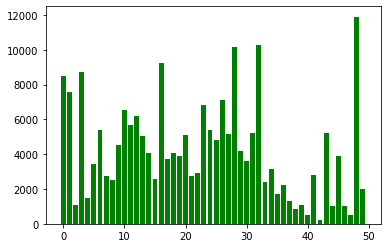

In [66]:
import matplotlib.pyplot as plt

plt.bar(list(class_stat.keys()), class_stat.values(), color='g')
plt.show()

## Undersample whole ds

In [22]:
def resample(x_img, x_txt, y, n_instances):
    sorted_img = {}
    sorted_txt = {}
    
    for i in range(y.shape[0]):
        p = np.argmax(y[i])
        if p in sorted_img:
            sorted_img[p].append(x_img[i])
            sorted_txt[p].append(x_txt[i])
        else:
            sorted_img[p] = [x_img[i]]
            sorted_txt[p] = [x_txt[i]]
    
    for k in sorted_img:
        c = list(zip(sorted_img[k], sorted_txt[k]))
        random.shuffle(c)
        sorted_img[k], sorted_txt[k] = zip(*c)
    
    img_list = []
    txt_list = []
    y_list = []
    
    for c in range(N_CLASSES):
        for i in range(n_instances):
            img_list.append(sorted_img[c][i % len(sorted_img[c])])
            txt_list.append(sorted_txt[c][i % len(sorted_txt[c])])
            y_list.append(to_categorical(c, N_CLASSES))
         
    x_img_rs = np.array(img_list)
    x_txt_rs = np.array(txt_list)
    y_rs = np.array(y_list)
    
    perm = np.random.permutation(len(y_rs))
    x_img_rs = x_img_rs[perm]
    x_txt_rs = x_txt_rs[perm]
    y_rs = y_rs[perm]
    
    return x_img_rs, x_txt_rs, y_rs

In [23]:
x_img_train_rs, x_txt_train_rs, y_train_rs = resample(x_img_train, x_txt_train, y_train, 500)

In [24]:
np.shape(x_img_train_rs)

(25000, 1024)

In [26]:
model_0 = get_model_custom_lr()
model_0.fit(
    [x_img_train_rs, x_txt_train_rs], 
    y_train_rs, 
    epochs=15, 
    validation_data=([x_img_val, x_txt_val], y_val))

Train on 25000 samples, validate on 33975 samples
Epoch 1/15
25000/25000 [==============================] - 7s 294us/sample - loss: 2.6548 - accuracy: 0.3073 - val_loss: 1.9772 - val_accuracy: 0.4887
Epoch 2/15
25000/25000 [==============================] - 5s 206us/sample - loss: 2.0456 - accuracy: 0.4557 - val_loss: 1.8286 - val_accuracy: 0.5276
Epoch 3/15
25000/25000 [==============================] - 5s 216us/sample - loss: 1.8931 - accuracy: 0.4908 - val_loss: 1.7872 - val_accuracy: 0.5290
Epoch 4/15
25000/25000 [==============================] - 5s 218us/sample - loss: 1.8033 - accuracy: 0.5132 - val_loss: 1.7625 - val_accuracy: 0.5361
Epoch 5/15
25000/25000 [==============================] - 6s 231us/sample - loss: 1.7373 - accuracy: 0.5306 - val_loss: 1.7718 - val_accuracy: 0.5387
Epoch 6/15
25000/25000 [==============================] - 6s 235us/sample - loss: 1.6856 - accuracy: 0.5384 - val_loss: 1.7441 - val_accuracy: 0.5388
Epoch 7/15
25000/25000 [==========================

In [117]:
ev

[1.826279037487398, 0.53842896]

In [ ]:
y_pred_0 = model_0.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_0, axis=1), np.argmax(y_test, axis=1)))

In [126]:
x_img_train_rs_1000, x_txt_train_rs_1000, y_train_rs_1000 = resample(x_img_train, x_txt_train, y_train, 1000)

In [127]:
model_0_1000 = get_model_one_narrow_dense()
model_0_1000.fit([x_img_train_rs_1000, x_txt_train_rs_1000], y_train_rs_1000, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 135us/sample - loss: 2.5109 - accuracy: 0.4219 - val_loss: 1.7300 - val_accuracy: 0.5569
Epoch 2/10
40000/40000 [==============================] - 6s 143us/sample - loss: 1.8888 - accuracy: 0.5134 - val_loss: 1.6956 - val_accuracy: 0.5587
Epoch 3/10
40000/40000 [==============================] - 7s 175us/sample - loss: 1.7922 - accuracy: 0.5290 - val_loss: 1.6652 - val_accuracy: 0.5600
Epoch 4/10
40000/40000 [==============================] - 5s 130us/sample - loss: 1.7541 - accuracy: 0.5371 - val_loss: 1.6705 - val_accuracy: 0.5595
Epoch 5/10
40000/40000 [==============================] - 5s 128us/sample - loss: 1.7143 - accuracy: 0.5488 - val_loss: 1.6612 - val_accuracy: 0.5603
Epoch 6/10
40000/40000 [==============================] - 5s 125us/sample - loss: 1.6977 - accuracy: 0.5491 - val_loss: 1.6566 - val_accuracy: 0.5694
Epoch 7/10
40000/40000 [==========================

In [128]:
ev_0_1000 = model_0_1000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)

In [129]:
print(ev_0_1000)

[1.7476211049310386, 0.540195]


In [135]:
y_pred_0_1000 = model_0_1000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_0_1000, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1481
           1       0.54      0.60      0.57      1342
           2       0.85      0.50      0.63       351
           3       0.76      0.82      0.79      1603
           4       0.67      0.41      0.51       509
           5       0.54      0.34      0.42       983
           6       0.75      0.91      0.82       848
           7       0.68      0.60      0.64       579
           8       0.80      0.44      0.57       859
           9       0.71      0.71      0.71       870
          10       0.83      0.87      0.85      1207
          11       0.72      0.82      0.77      1009
          12       0.50      0.52      0.51      1226
          13       0.70      0.65      0.67      1107
          14       0.57      0.50      0.53       907
          15       0.70      0.37      0.48       963
          16       0.47      0.84      0.60      1051
          17       0.51    

In [157]:
x_img_train_rs_2000, x_txt_train_rs_2000, y_train_rs_2000 = resample(x_img_train, x_txt_train, y_train, 2000)

model_lh_2000 = get_model_longhorns()
model_lh_2000.fit([x_img_train_rs_2000, x_txt_train_rs_2000], y_train_rs_2000, epochs=10, validation_split=0.2)

ev_lh_2000 = model_lh_2000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_lh_2000)

y_pred_lh_2000 = model_lh_2000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_lh_2000, axis=1), np.argmax(y_test, axis=1)))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 12s 144us/sample - loss: 2.2314 - accuracy: 0.4170 - val_loss: 1.7591 - val_accuracy: 0.5304
Epoch 2/10
80000/80000 [==============================] - 12s 150us/sample - loss: 1.8523 - accuracy: 0.5081 - val_loss: 1.6762 - val_accuracy: 0.5529
Epoch 3/10
80000/80000 [==============================] - 8s 105us/sample - loss: 1.7587 - accuracy: 0.5329 - val_loss: 1.6265 - val_accuracy: 0.5634
Epoch 4/10
80000/80000 [==============================] - 8s 104us/sample - loss: 1.7001 - accuracy: 0.5460 - val_loss: 1.5983 - val_accuracy: 0.5691
Epoch 5/10
80000/80000 [==============================] - 10s 125us/sample - loss: 1.6569 - accuracy: 0.5557 - val_loss: 1.5779 - val_accuracy: 0.5762
Epoch 6/10
80000/80000 [==============================] - 11s 140us/sample - loss: 1.6260 - accuracy: 0.5629 - val_loss: 1.5614 - val_accuracy: 0.5795
Epoch 7/10
80000/80000 [======================

In [163]:
x_img_train_rs_3000, x_txt_train_rs_3000, y_train_rs_3000 = resample(x_img_train, x_txt_train, y_train, 3000)

model_lh_3000 = get_model_longhorns()
model_lh_3000.fit([x_img_train_rs_3000, x_txt_train_rs_3000], y_train_rs_3000, epochs=10, validation_split=0.2)

ev_lh_3000 = model_lh_3000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_lh_3000)

y_pred_lh_3000 = model_lh_3000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_lh_3000, axis=1), np.argmax(y_test, axis=1)))

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 18s 150us/sample - loss: 2.1282 - accuracy: 0.4415 - val_loss: 1.6779 - val_accuracy: 0.5527
Epoch 2/10
120000/120000 [==============================] - 17s 139us/sample - loss: 1.7993 - accuracy: 0.5234 - val_loss: 1.5835 - val_accuracy: 0.5756
Epoch 3/10
120000/120000 [==============================] - 18s 149us/sample - loss: 1.7114 - accuracy: 0.5443 - val_loss: 1.5502 - val_accuracy: 0.5817
Epoch 4/10
120000/120000 [==============================] - 16s 131us/sample - loss: 1.6574 - accuracy: 0.5562 - val_loss: 1.5226 - val_accuracy: 0.5884
Epoch 5/10
120000/120000 [==============================] - 18s 153us/sample - loss: 1.6177 - accuracy: 0.5653 - val_loss: 1.5004 - val_accuracy: 0.5969
Epoch 6/10
120000/120000 [==============================] - 16s 130us/sample - loss: 1.5873 - accuracy: 0.5723 - val_loss: 1.4867 - val_accuracy: 0.5983
Epoch 7/10
120000/120000 [=====

In [164]:
x_img_train_rs_4000, x_txt_train_rs_4000, y_train_rs_4000 = resample(x_img_train, x_txt_train, y_train, 4000)

model_lh_4000 = get_model_longhorns()
model_lh_4000.fit([x_img_train_rs_4000, x_txt_train_rs_4000], y_train_rs_4000, epochs=10, validation_split=0.2)

ev_lh_4000 = model_lh_4000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_lh_4000)

y_pred_lh_4000 = model_lh_4000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_lh_4000, axis=1), np.argmax(y_test, axis=1)))

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 30s 187us/sample - loss: 2.0459 - accuracy: 0.4599 - val_loss: 1.6474 - val_accuracy: 0.5616
Epoch 2/10
160000/160000 [==============================] - 29s 182us/sample - loss: 1.7554 - accuracy: 0.5335 - val_loss: 1.5672 - val_accuracy: 0.5803
Epoch 3/10
160000/160000 [==============================] - 26s 165us/sample - loss: 1.6738 - accuracy: 0.5524 - val_loss: 1.5344 - val_accuracy: 0.5877
Epoch 4/10
160000/160000 [==============================] - 29s 181us/sample - loss: 1.6244 - accuracy: 0.5644 - val_loss: 1.4955 - val_accuracy: 0.5971
Epoch 5/10
160000/160000 [==============================] - 27s 167us/sample - loss: 1.5909 - accuracy: 0.5725 - val_loss: 1.4685 - val_accuracy: 0.6048
Epoch 6/10
160000/160000 [==============================] - 21s 132us/sample - loss: 1.5636 - accuracy: 0.5788 - val_loss: 1.4619 - val_accuracy: 0.6072
Epoch 7/10
160000/160000 [=====

In [166]:
x_img_train_rs_5000, x_txt_train_rs_5000, y_train_rs_5000 = resample(x_img_train, x_txt_train, y_train, 5000)

model_lh_5000 = get_model_longhorns()
model_lh_5000.fit([x_img_train_rs_5000, x_txt_train_rs_5000], y_train_rs_5000, epochs=10, validation_split=0.2)

ev_lh_5000 = model_lh_5000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_lh_5000)

y_pred_lh_5000 = model_lh_5000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_lh_5000, axis=1), np.argmax(y_test, axis=1)))

Train on 200000 samples, validate on 50000 samples
Epoch 1/10
200000/200000 [==============================] - 40s 199us/sample - loss: 2.0033 - accuracy: 0.4728 - val_loss: 1.5901 - val_accuracy: 0.5723
Epoch 2/10
200000/200000 [==============================] - 33s 165us/sample - loss: 1.7245 - accuracy: 0.5416 - val_loss: 1.5163 - val_accuracy: 0.5887
Epoch 3/10
200000/200000 [==============================] - 21s 106us/sample - loss: 1.6468 - accuracy: 0.5588 - val_loss: 1.4741 - val_accuracy: 0.6008
Epoch 4/10
200000/200000 [==============================] - 23s 114us/sample - loss: 1.6012 - accuracy: 0.5697 - val_loss: 1.4384 - val_accuracy: 0.6080
Epoch 5/10
200000/200000 [==============================] - 24s 118us/sample - loss: 1.5654 - accuracy: 0.5793 - val_loss: 1.4153 - val_accuracy: 0.6138
Epoch 6/10
200000/200000 [==============================] - 22s 109us/sample - loss: 1.5396 - accuracy: 0.5859 - val_loss: 1.4107 - val_accuracy: 0.6147
Epoch 7/10
200000/200000 [=====

In [27]:
x_img_train_rs_8000, x_txt_train_rs_8000, y_train_rs_8000 = resample(x_img_train, x_txt_train, y_train, 8000)


Train on 400000 samples, validate on 33975 samples
Epoch 1/15
400000/400000 [==============================] - 120s 300us/sample - loss: 1.8543 - accuracy: 0.5083 - val_loss: 1.6322 - val_accuracy: 0.5616
Epoch 2/15
389696/400000 [============================>.] - ETA: 5s - loss: 1.6017 - accuracy: 0.5699

KeyboardInterrupt: 

In [33]:
model_8000 = get_model_custom_lr()
model_8000.fit(
    [x_img_train_rs_8000, x_txt_train_rs_8000], 
    y_train_rs_8000, 
    epochs=15, 
    validation_data=([x_img_val, x_txt_val], y_val),
    batch_size=4096
)

ev_8000 = model_8000.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_lh_8000)

y_pred_8000 = model_8000.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_8000, axis=1), np.argmax(y_test, axis=1)))

Train on 400000 samples, validate on 33975 samples
Epoch 1/15
 73728/400000 [====>.........................] - ETA: 7:40 - loss: 3.7173 - accuracy: 0.0896

KeyboardInterrupt: 

Смотря на разницу в валидационных и тестовых метриках можно сделать вывод, что модель, которая натренированна на сбалансированных данных, и работает лучше на них. Поэтому этот подход не очень подходит для решения реальной задачи

In [118]:
model_1 = get_model_one_wide_dense()
model_1.fit([x_img_train_rs, x_txt_train_rs], y_train_rs, epochs=10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 577us/sample - loss: 3.7933 - accuracy: 0.3966 - val_loss: 3.0377 - val_accuracy: 0.4610
Epoch 2/10
20000/20000 [==============================] - 8s 424us/sample - loss: 2.7779 - accuracy: 0.4830 - val_loss: 2.7361 - val_accuracy: 0.4870
Epoch 3/10
20000/20000 [==============================] - 9s 463us/sample - loss: 2.4511 - accuracy: 0.5013 - val_loss: 2.6618 - val_accuracy: 0.4776
Epoch 4/10
20000/20000 [==============================] - 9s 466us/sample - loss: 2.3658 - accuracy: 0.5124 - val_loss: 2.7531 - val_accuracy: 0.4884
Epoch 5/10
20000/20000 [==============================] - 9s 458us/sample - loss: 2.3746 - accuracy: 0.5196 - val_loss: 2.8344 - val_accuracy: 0.4858
Epoch 6/10
20000/20000 [==============================] - 7s 326us/sample - loss: 2.4233 - accuracy: 0.5218 - val_loss: 2.9834 - val_accuracy: 0.4926
Epoch 7/10
20000/20000 [==========================

In [151]:
ev_1 = model_1.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_1)

[3.486500201414363, 0.46790525]


In [153]:
model_s = get_model_s()
model_s.fit([x_img_train_rs_1000, x_txt_train_rs_1000], y_train_rs_1000, epochs=10, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 149s 4ms/sample - loss: 14.3514 - accuracy: 0.2629 - val_loss: 20.0662 - val_accuracy: 0.3955
Epoch 2/10
40000/40000 [==============================] - 148s 4ms/sample - loss: 300.9281 - accuracy: 0.1913 - val_loss: 184.0362 - val_accuracy: 0.3576
Epoch 3/10
40000/40000 [==============================] - 119s 3ms/sample - loss: 175.5903 - accuracy: 0.2276 - val_loss: 49.7183 - val_accuracy: 0.4108
Epoch 4/10
40000/40000 [==============================] - 142s 4ms/sample - loss: 91.5215 - accuracy: 0.2509 - val_loss: 34.6427 - val_accuracy: 0.4088
Epoch 5/10
40000/40000 [==============================] - 127s 3ms/sample - loss: 72.4504 - accuracy: 0.2559 - val_loss: 30.3267 - val_accuracy: 0.4227
Epoch 6/10
40000/40000 [==============================] - 113s 3ms/sample - loss: 180.9802 - accuracy: 0.2226 - val_loss: 144.9776 - val_accuracy: 0.3388
Epoch 7/10
40000/40000 [=========

In [154]:
ev_s = model_s.evaluate([x_img_test, x_txt_test], y_test, verbose=0)
print(ev_s)

[85.2089955276988, 0.4065414]


In [155]:
y_pred_s = model_s.predict([x_img_test, x_txt_test])
print(classification_report(np.argmax(y_pred_s, axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1859
           1       0.39      0.47      0.42      1243
           2       0.79      0.32      0.45       510
           3       0.70      0.67      0.69      1816
           4       0.30      0.36      0.33       260
           5       0.21      0.25      0.23       525
           6       0.80      0.80      0.80      1025
           7       0.27      0.43      0.33       323
           8       0.71      0.10      0.18      3213
           9       0.54      0.67      0.60       708
          10       0.85      0.77      0.81      1394
          11       0.63      0.65      0.64      1116
          12       0.17      0.38      0.24       568
          13       0.66      0.49      0.56      1364
          14       0.32      0.34      0.33       738
          15       0.10      0.29      0.15       175
          16       0.44      0.41      0.42      2024
          17       0.59    